## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Settings

In [2]:
# dimensions of our images.
img_height, img_width = 200, 200

data_dir = '../input/no-obs-diffs/no_obs_diffs'
epochs = 50
batch_size = 32
reg = l1_l2(0.01)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

input_shape = (img_height, img_width, 1)

## Metrics Definition

In [3]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

## Model Definition

In [4]:
inp = Input(shape=input_shape)

x = Conv2D(8, (3, 3), padding='same', activation = 'relu', 
           kernel_regularizer=reg, bias_regularizer=reg)(inp)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(16, (5, 5), padding='same', activation = 'relu',
          kernel_regularizer=reg, bias_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), padding='same', activation = 'relu',
          kernel_regularizer=reg, bias_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(64, (5, 5), padding='same', activation = 'relu',
          kernel_regularizer=reg, bias_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(4, 4), padding='same')(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01))(x)

model = Model(inp, out)
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 8)       80        
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)       

## Data Generators Definition

In [5]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator(
    validation_split=0.3,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 12457 images belonging to 2 classes.
Found 5338 images belonging to 2 classes.


## Run the Model

In [6]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/50
390/390 [==============================] - 92s 235ms/step - loss: 16.2521 - tp: 5110.0000 - fp: 872.0000 - tn: 5642.0000 - fn: 833.0000 - accuracy: 0.8631 - precision: 0.8542 - recall: 0.8598 - auc: 0.9358 - val_loss: 12.5211 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2791.0000 - val_fn: 2547.0000 - val_accuracy: 0.5229 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5718
Epoch 2/50
390/390 [==============================] - 66s 169ms/step - loss: 8.4548 - tp: 5423.0000 - fp: 421.0000 - tn: 6093.0000 - fn: 520.0000 - accuracy: 0.9245 - precision: 0.9280 - recall: 0.9125 - auc: 0.9742 - val_loss: 6.0980 - val_tp: 1997.0000 - val_fp: 237.0000 - val_tn: 2554.0000 - val_fn: 550.0000 - val_accuracy: 0.8526 - val_precision: 0.8939 - val_recall: 0.7841 - val_auc: 0.9053
Epoch 3/50
390/390 [==============================] - 67s 171ms/step - loss: 4.3819 - tp: 5522.0000 - fp: 334.0000 - tn: 6180.0000 - fn: 421.0000 - accuracy: 0.9394 - precision: 0.9430 - r

Epoch 00020: early stopping


## Plot Settings

In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Analyze the Metrics

In [8]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

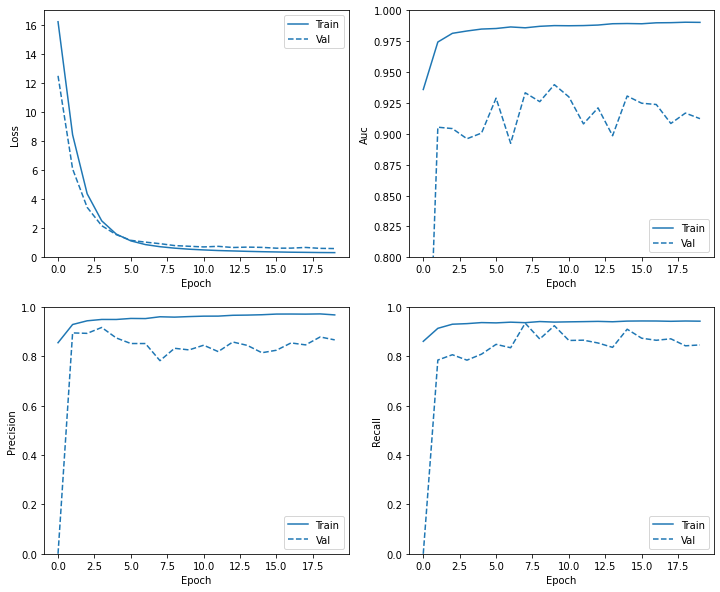

In [9]:
plot_metrics(history)

## Save the Model

In [10]:
#model.save('no_obs')